# Data Description

These datasets are meteorological data from the HI-SEAS weather station from four months (September through December 2016) between Mission IV and Mission V.

For each dataset, the fields are:

A row number (1-n) useful in sorting this export's results
The UNIX time_t date (seconds since Jan 1, 1970). Useful in sorting this export's results with other export's results
The date in yyyy-mm-dd format
The local time of day in hh:mm:ss 24-hour format
The numeric data, if any (may be an empty string)
The text data, if any (may be an empty string)

The units of each dataset are:

- Solar radiation: watts per meter^2
- Temperature: degrees Fahrenheit
- Humidity: percent
- Barometric pressure: Hg
- Wind direction: degrees
- Wind speed: miles per hour
- Sunrise/sunset: Hawaii time

Link: https://www.kaggle.com/datasets/dronio/SolarEnergy

# Table of Content

1. Importing Libraries
2. Loading Data
3. Data Wrangling
4. Feature Selection using Correlation Matrix
5. Feature Selection using SelectKBest Method
6. Feature Selection using Extra Tree Classifier
7. Feature Engineering with BoxCox, Log, Min-Max and Standard transformation
8. Preparing data - Standardisation and Splitting
9. Prediction with XGBoost
10. Using MultiLayer Perceptron for prediction

# Importing Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split

#!pip install xgboost
import xgboost as xgb


from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from collections import Counter

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Loading Data

In [2]:
data = pd.read_csv("SolarPrediction.csv")
data.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


In [4]:
df = data.copy()

# Data Wrangling

In [5]:
# extract the date from the date_time format of the 'Data' parameter
df['Data'] = df['Data'].apply(lambda x : x.split()[0])

In [6]:
# extract the date time features from the given parameter using date time python methods
df['Month'] = pd.to_datetime(df['Data']).dt.month
df['Year'] = pd.to_datetime(df['Data']).dt.year
df['Hour'] = pd.to_datetime(df['Time']).dt.hour
df['Minute'] = pd.to_datetime(df['Time']).dt.minute
df['Seconds'] = pd.to_datetime(df['Time']).dt.second

In [7]:
# extract the sunrise and sunset information using regular expression
df['RiseHour']   = df['TimeSunRise'].apply(lambda x : re.search(r'^\d+' , x).group(0)).astype(int)
df['RiseMinute'] = df['TimeSunRise'].apply(lambda x : re.search (r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)

df['SetHour'] =  df['TimeSunSet'].apply(lambda x : re.search (r'^\d+' , x).group(0)).astype(int)
df['SetMinute'] =  df['TimeSunSet'].apply(lambda x : re.search (r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)


In [8]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Year,Hour,Minute,Seconds,RiseHour,RiseMinute,SetHour,SetMinute
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,2016,23,55,26,6,13,18,13
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,2016,23,50,23,6,13,18,13
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,2016,23,45,26,6,13,18,13
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,2016,23,40,21,6,13,18,13
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,2016,23,35,24,6,13,18,13


In [9]:
# drop the parameters that are not required after extracting the relevant information
df.drop(['UNIXTime',"Data","Time","TimeSunRise","TimeSunSet"], axis =1 , inplace= True)

In [10]:
# check of data dimensions
df.shape

(32686, 15)

In [11]:
# checking for null values in the data
df.isna().sum().sum()

0

In [12]:
# glimpse of the final data
df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Year,Hour,Minute,Seconds,RiseHour,RiseMinute,SetHour,SetMinute
0,1.21,48,30.46,59,177.39,5.62,9,2016,23,55,26,6,13,18,13
1,1.21,48,30.46,58,176.78,3.37,9,2016,23,50,23,6,13,18,13
2,1.23,48,30.46,57,158.75,3.37,9,2016,23,45,26,6,13,18,13
3,1.21,48,30.46,60,137.71,3.37,9,2016,23,40,21,6,13,18,13
4,1.17,48,30.46,62,104.95,5.62,9,2016,23,35,24,6,13,18,13


In [13]:
# Set input_faetures and target 

input_features = df.drop(['Radiation'], axis= 1)
target = df["Radiation"]

# Feature Selection using Correlation Matrix

$$
r=\frac{\sum\left(x_i-\bar{x}\right)\left(y_i-\bar{y}\right)}{\sqrt{\sum\left(x_i-\bar{x}\right)^2 \sum\left(y_i-\bar{y}\right)^2}}
$$
- $r=$ correlation coefficient
- $x_i=$ values of the $\mathrm{x}$-variable in a sample
- $\bar{x}=$ mean of the values of the $\mathrm{x}$-variable
- $y_i=$ values of the $y$-variable in a sample
- $\bar{y}=$ mean of the values of the $y$-variable

In [14]:
# extract the correlation between the data features


In [15]:
corr = df.corr()
corr

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Year,Hour,Minute,Seconds,RiseHour,RiseMinute,SetHour,SetMinute
Radiation,1.000000,0.734955,0.119016,-0.226171,-0.230324,0.073627,-0.095450,NaN,0.004398,-0.000730,-0.031270,NaN,-0.092850,0.048719,-0.039816
Temperature,0.734955,1.000000,0.311173,-0.285055,-0.259421,-0.031458,-0.354560,NaN,0.197464,-0.001934,-0.036147,NaN,-0.380968,0.300920,-0.242881
Pressure,0.119016,0.311173,1.000000,-0.223973,-0.229010,-0.083639,-0.341759,NaN,0.091069,0.001860,-0.031102,NaN,-0.380399,0.151939,-0.119599
Humidity,-0.226171,-0.285055,-0.223973,1.000000,-0.001833,-0.211624,-0.068854,NaN,0.077899,0.000499,-0.027682,NaN,-0.023955,0.145143,-0.119526
WindDirection(Degrees),-0.230324,-0.259421,-0.229010,-0.001833,1.000000,0.073092,0.181485,NaN,-0.077969,-0.000602,-0.032568,NaN,0.176929,-0.078540,0.070030
Speed,0.073627,-0.031458,-0.083639,-0.211624,0.073092,1.000000,0.150822,NaN,-0.057939,0.000192,-0.032934,NaN,0.167075,-0.159384,0.119926
Month,-0.095450,-0.354560,-0.341759,-0.068854,0.181485,0.150822,1.000000,NaN,-0.005396,0.000168,0.220563,NaN,0.952472,-0.784783,0.541883
Year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hour,0.004398,0.197464,0.091069,0.077899,-0.077969,-0.057939,-0.005396,NaN,1.000000,-0.004052,0.004199,NaN,-0.006772,0.008629,-0.007056
Minute,-0.000730,-0.001934,0.001860,0.000499,-0.000602,0.000192,0.000168,NaN,-0.004052,1.000000,0.002517,NaN,-0.000158,0.001052,-0.002215


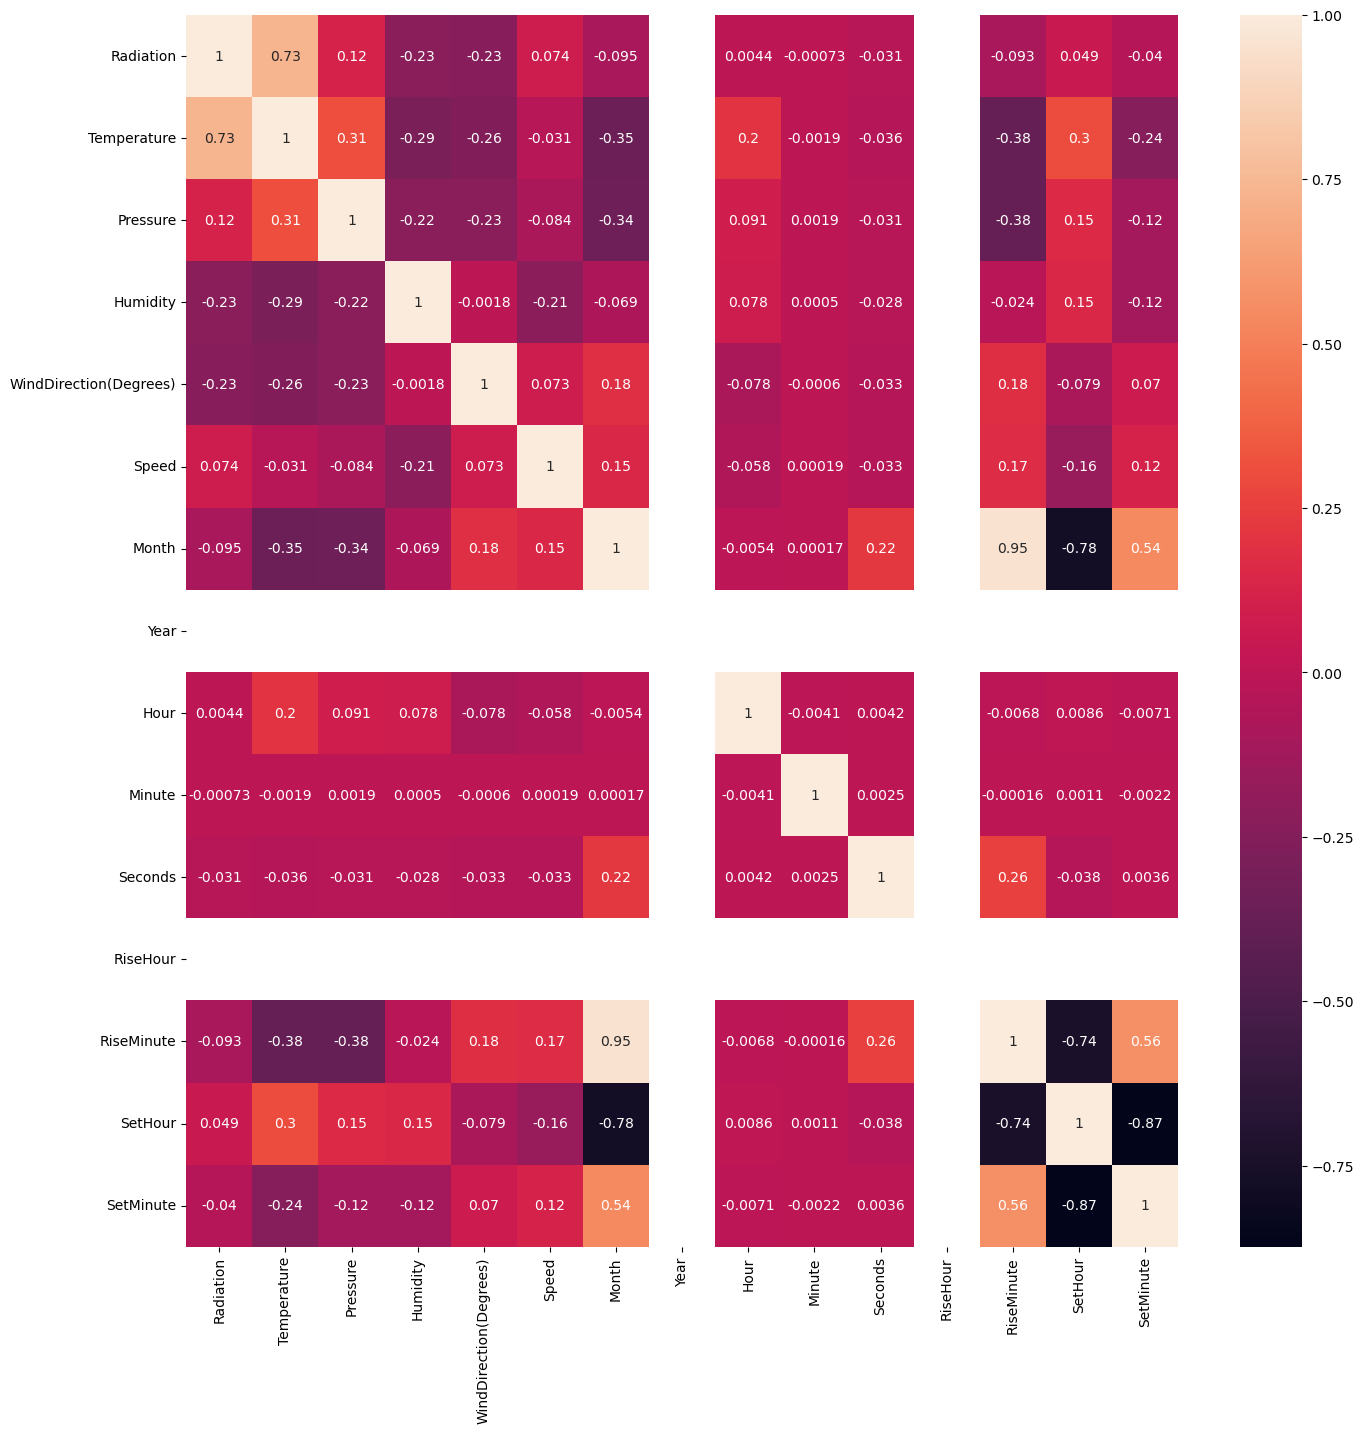

In [16]:
# plot the correlation matrix using heatmap for clear understanding
plt.figure(figsize=(16,16))
sns.heatmap(corr, annot=True)
plt.show()

# Feature Selection using SelectKBest Method

GFG article link to $chi^{2}$ test - https://www.geeksforgeeks.org/chi-square-test-for-feature-selection-mathematical-explanation/

It works on the target label but instead we are passsing continuous float values to it. So, we need to convert our data to label form and there are two methods as follows:
- usign LabelEncoder
- multiplying the data by 100 and converting it to int which can be treated as labels by the model

In [17]:
# use the label encoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_Y = label_encoder.fit_transform(target)

In [18]:
train_Y

array([ 9,  9, 11, ...,  8, 11,  8], dtype=int64)

In [19]:
#create a model for bestfeature
bestfeature = SelectKBest(score_func=chi2, k=10)

target_cont = df['Radiation'].apply(lambda x: int(100*x))

scaled_inputFeature = MinMaxScaler().fit_transform(input_features)
fit = bestfeature.fit(scaled_inputFeature , target_cont)

In [20]:
scores = pd.DataFrame(fit.scores_)
cols = pd.DataFrame(input_features.columns )

In [21]:
# Contatinating Feature with the scores
featureScores = pd.concat([cols, scores], axis=1)

#naming the dataframe columns
featureScores.columns = ['Features', 'Feature_imp'] 

In [22]:
# best features
featureScores.sort_values(by ="Feature_imp", ascending=False, inplace=True)

In [23]:
featureScores

,Features,Feature_imp
12,SetHour,12207.531454
5,Month,4684.579610
11,RiseMinute,4015.062771
3,WindDirection(Degrees),3271.827277
8,Minute,2702.449333
9,Seconds,2288.673032
13,SetMinute,1863.712087
0,Temperature,1651.685632
2,Humidity,1588.087433
4,Speed,765.859779


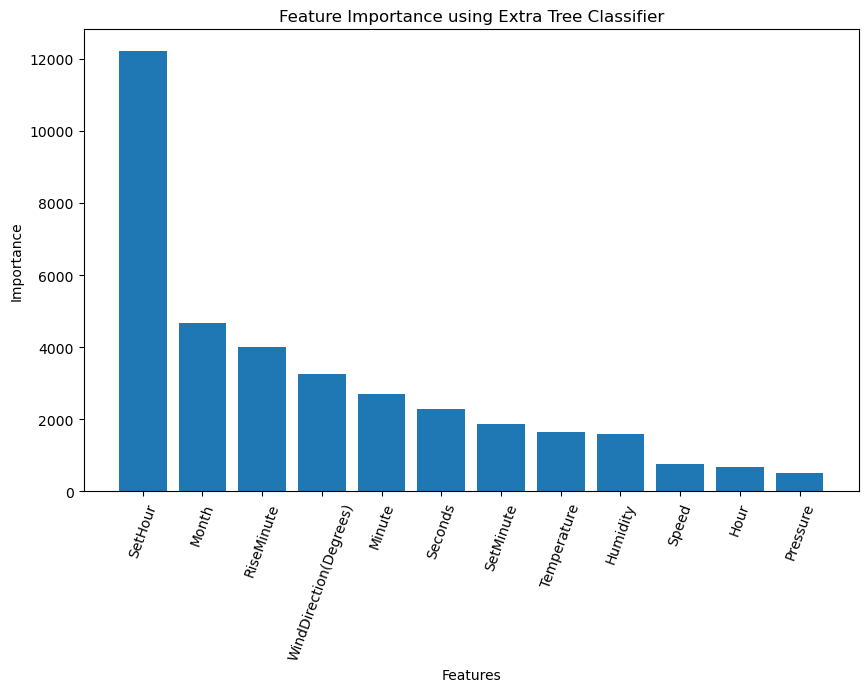

In [24]:
# visualise the feature importance
plt.figure(figsize = (10, 6))
plt.bar(featureScores["Features"],featureScores["Feature_imp"])
plt.xticks(rotation = 70)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance using Extra Tree Classifier")
plt.show()

# Feature Selection using Extra Tree Classifier

In [25]:
model = ExtraTreesClassifier(verbose = 2, n_estimators = 10)
model.fit(scaled_inputFeature, target_cont)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 5


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.1s remaining:    0.0s


building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min finished


ExtraTreesClassifier(n_estimators=5, verbose=2)

In [26]:
feature_importances = pd.DataFrame(model.feature_importances_, index = input_features.columns, columns = ["Feature_imp"])
feature_importances.sort_values(by = 'Feature_imp', ascending=False, inplace = True)
feature_importances

,Feature_imp
WindDirection(Degrees),0.158518
Minute,0.147622
Speed,0.123690
Seconds,0.123227
Humidity,0.111177
Hour,0.092281
Temperature,0.083807
Pressure,0.080138
SetMinute,0.037572
RiseMinute,0.035116


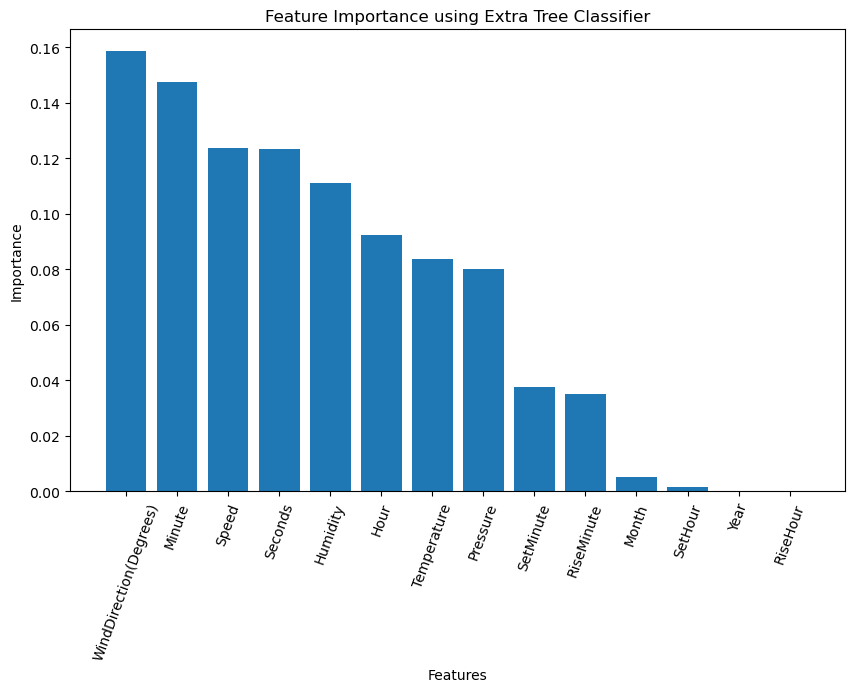

In [27]:
plt.figure(figsize = (10, 6))
plt.bar(feature_importances.index, feature_importances["Feature_imp"])
plt.xticks(rotation = 70)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance using Extra Tree Classifier")
plt.show()

# Feature Engineering with BoxCox, Log, Min-Max and Standard transformation

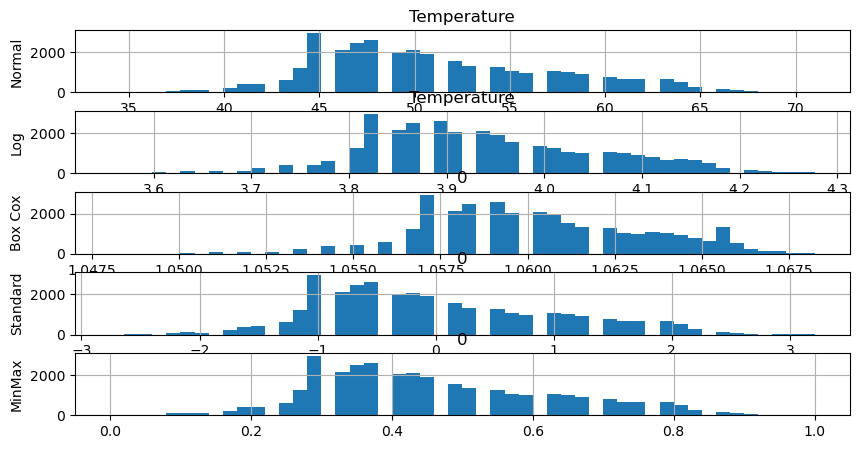

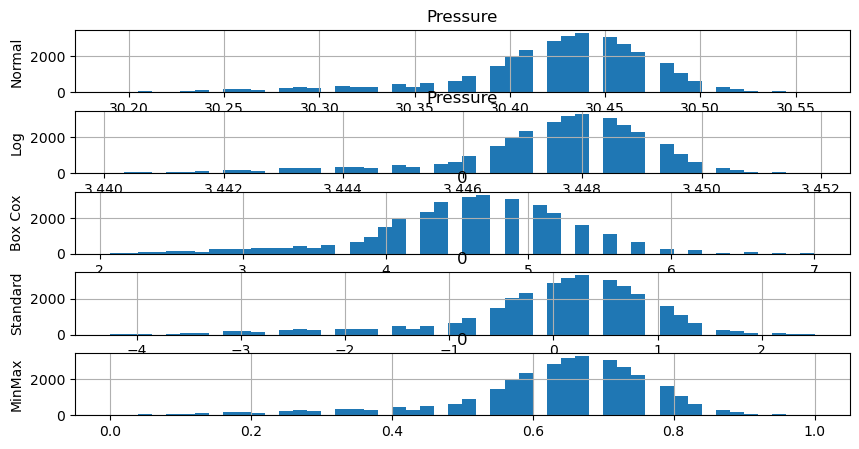

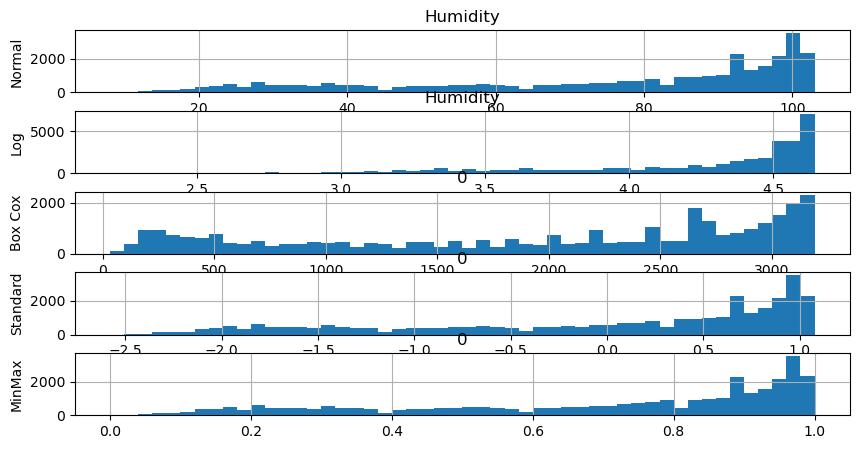

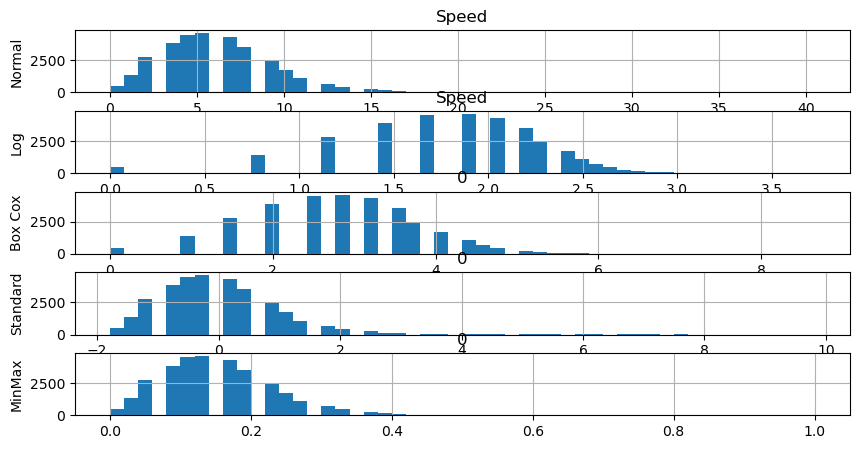

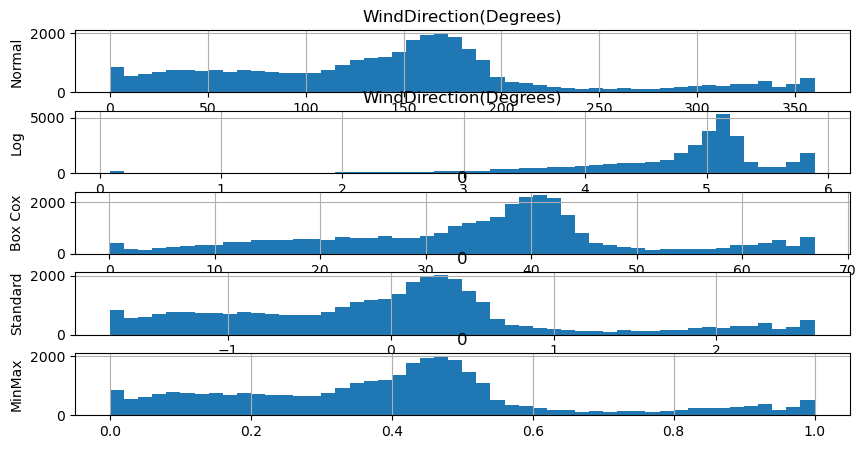

In [25]:
# Looking for transformation
features_to_transform = ['Temperature', 'Pressure', 'Humidity', 'Speed', 'WindDirection(Degrees)']

for i in features_to_transform:
    
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(10, 5))
    
    pd.DataFrame(input_features[i]).hist(ax = ax1, bins = 50)
    pd.DataFrame((input_features[i]+1).transform(np.log)).hist(ax = ax2, bins = 50)
    pd.DataFrame(stats.boxcox(input_features[i]+1)[0]).hist(ax = ax3, bins = 50)    
    pd.DataFrame(StandardScaler().fit_transform(np.array(input_features[i]).reshape(-1, 1))).hist(ax = ax4, bins = 50)
    pd.DataFrame(MinMaxScaler().fit_transform(np.array(input_features[i]).reshape(-1, 1))).hist(ax = ax5, bins = 50)
    
    ax1.set_ylabel('Normal')
    ax2.set_ylabel('Log')
    ax3.set_ylabel('Box Cox')
    ax4.set_ylabel('Standard')
    ax5.set_ylabel('MinMax')

In [26]:
# set the transformations required
transform = {'Temperature' : (input_features['Temperature']+1).transform(np.log), 
             'Pressure': stats.boxcox(input_features['Pressure']+1)[0], 
            'Humidity' : stats.boxcox(input_features['Humidity']+1)[0], 
            'Speed' : (input_features['Speed']+1).transform(np.log), 
            'WindDirection(Degrees)' : MinMaxScaler().fit_transform(
                np.array(input_features['WindDirection(Degrees)']).reshape(-1, 1))}

for i in transform:
    input_features[i] = transform[i]

In [27]:
input_features.head()

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Year,Hour,Minute,Seconds,RiseHour,RiseMinute,SetHour,SetMinute
0,3.89182,5.044903e+152,1139.358665,0.492692,1.890095,9,2016,23,55,26,6,13,18,13
1,3.89182,5.044903e+152,1104.046980,0.490996,1.474763,9,2016,23,50,23,6,13,18,13
2,3.89182,5.044903e+152,1069.253545,0.440894,1.474763,9,2016,23,45,26,6,13,18,13
3,3.89182,5.044903e+152,1175.187489,0.382426,1.474763,9,2016,23,40,21,6,13,18,13
4,3.89182,5.044903e+152,1248.392213,0.291391,1.890095,9,2016,23,35,24,6,13,18,13


# Preparing data - Standardisation and Splitting

In [28]:
xtrain, xtest, ytrain, ytest = train_test_split(input_features, target, test_size=0.2, random_state=1)

scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

In [29]:
xtrain.shape, xtest.shape

((26148, 14), (6538, 14))

# Prediction with XGBoost

In [30]:
# declare parameters
params = {
    'learning_rate': 0.1,
    'max_depth': 8}

from xgboost import XGBRegressor
model = XGBRegressor(**params)

In [31]:
# train the model
model.fit(xtrain, ytrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [32]:
y_pred = model.predict(xtest)

In [33]:
print('XGBoost model result: {0:0.4f}'. format(np.sqrt(mean_squared_error(ytest, y_pred))))

XGBoost model result: 83.5828


In [34]:
rmse = np.sqrt(mean_squared_error(ytest, y_pred))
r2 = r2_score(ytest, y_pred)

print("Testing performance")

print("RMSE: {:.2f}".format(rmse))
print("R2: {:.2f}".format(r2))

Testing performance
RMSE: 83.58
R2: 0.93


# Using MultiLayer Perceptron for prediction

In [35]:
xtrain, xtest, ytrain, ytest = train_test_split(input_features, target, test_size=0.2, random_state=1)

scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

In [37]:
model = None
model = Sequential()
    
model.add(Dense(128, activation='relu', input_dim=14))
model.add(Dropout(0.33))
    
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.33))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.33))

model.add(Dense(1, activation='linear'))
    
model.compile(metrics=['mse'], loss='mae', optimizer=Adam(learning_rate=0.001))
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 128)                 │           1,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,289 (48.00 KB)

 Trainable params: 12,289 (48.00 KB)

 Non-trainable params: 0 (0.00 B)

None


In [38]:
history = model.fit(xtrain, ytrain, validation_split=0.1, epochs=50, batch_size=32)


Epoch 1/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 157.9728 - mse: 90097.9219 - val_loss: 80.4276 - val_mse: 23605.4219
Epoch 2/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 87.6954 - mse: 28476.8887 - val_loss: 72.4493 - val_mse: 19413.4355
Epoch 3/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 80.2205 - mse: 24365.7617 - val_loss: 68.7119 - val_mse: 17899.1074
Epoch 4/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 77.6944 - mse: 22697.8574 - val_loss: 63.0543 - val_mse: 15539.1816
Epoch 5/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 75.3207 - mse: 21798.1348 - val_loss: 62.6854 - val_mse: 15605.6523
Epoch 6/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 73.7639 - mse: 20933.7812 - val_loss: 57.9725 - val_mse: 13854.7822
Epoch 7/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 69.3049 - mse: 19093.2363 - val_loss: 56.9437 - val_mse: 13524.1562
Epoch 8/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 70.6720 - mse: 19401.6230 - val_loss: 55.95

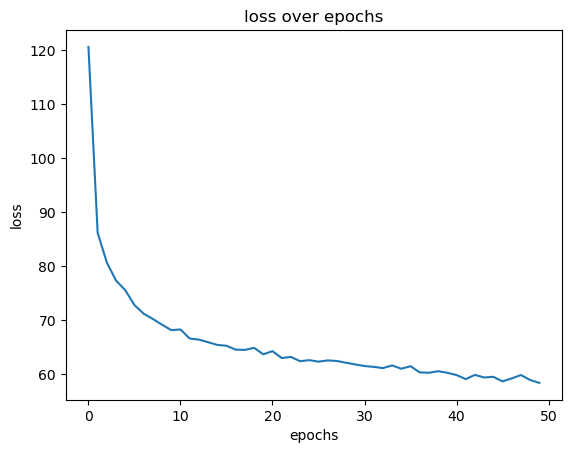

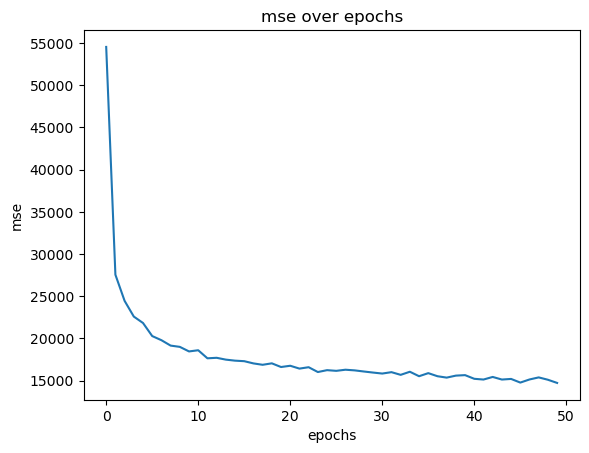

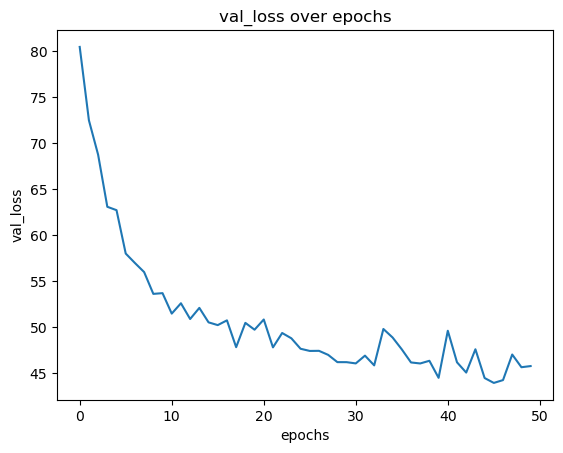

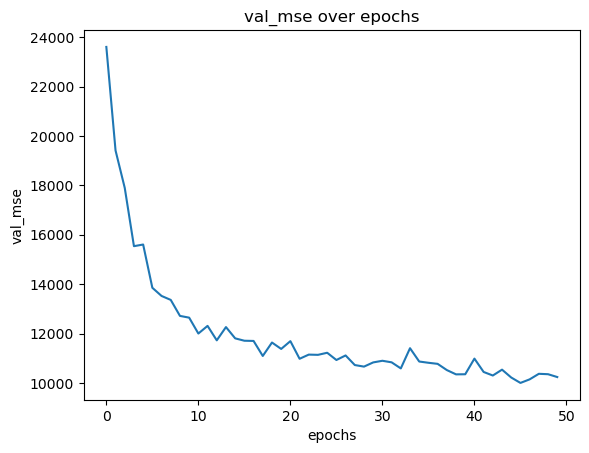

In [39]:
fit = history.history
for i in fit:
    plt.plot(fit[i])
    plt.title(i + ' over epochs')
    plt.ylabel(i)
    plt.xlabel('epochs')
    plt.show()

In [40]:
scores = model.evaluate(xtest, ytest)
mae = scores[0]
mse = scores[1]
print('Mean absolute error: ', mae)

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 46.4251 - mse: 10335.7227
Mean absolute error:  44.797218322753906


In [41]:
mean_absolute_error(ytest, model.predict(xtest))

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


44.797231391356526